In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Feature_extraction")

In [3]:
# Load score data
score_file_path = os.path.join(save_path,'score_by_device.pkl')
df_score = pd.read_pickle(score_file_path)

In [4]:
print(df_score.shape)
df_score.head()

(6909, 11)


,subject_id,visit,session,task_code,repetition,tremor_GENEActivHand,tremor_PebbleHand,dyskinesia_GENEActivHand,dyskinesia_PebbleHand,bradykinesia_GENEActivHand,bradykinesia_PebbleHand
0,3_BOS,1,1,stndg,1,0,0,Yes,Yes,NotApplicable,NotApplicable
0,3_BOS,1,1,wlkgs,1,0,0,Yes,Yes,No,No
0,3_BOS,1,1,wlkgc,1,0,0,Yes,Yes,No,No
0,3_BOS,1,1,strsu,1,0,0,Yes,No,No,No
0,3_BOS,1,1,strsd,1,0,0,No,Yes,No,No


In [5]:
subject_ids = df_score.subject_id.unique()

In [6]:
# load feature data
df_feature = pd.DataFrame()
device = 'GENEActiv'
for sb in subject_ids:
    feature_file_path = os.path.join(save_path,device,sb + '_features.pkl')
    df_feature_sb = pd.read_pickle(feature_file_path)
    df_feature = pd.concat([df_feature,df_feature_sb])


In [7]:
print(df_feature.shape)
df_feature.head()

(6909, 2262)


variable,x__abs_energy,x__absolute_sum_of_changes,"x__agg_autocorrelation__f_agg_""mean""__maxlag_40","x__agg_autocorrelation__f_agg_""median""__maxlag_40","x__agg_autocorrelation__f_agg_""var""__maxlag_40","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","x__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,z__symmetry_looking__r_0.9,z__symmetry_looking__r_0.9500000000000001,z__time_reversal_asymmetry_statistic__lag_1,z__time_reversal_asymmetry_statistic__lag_2,z__time_reversal_asymmetry_statistic__lag_3,z__value_count__value_-1,z__value_count__value_0,z__value_count__value_1,z__variance,z__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1679.603735,473.44306,0.095873,0.095139,0.034345,-0.855854,0.638863,0.015026,0.001439,-0.935256,...,1.0,1.0,0.006316,-0.000659,0.001838,0.0,0.0,0.0,0.136844,0.0
1,19055.256439,2362.42439,0.038591,-0.004983,0.028837,4.885473,-0.091550,-0.005762,0.004986,7.876297,...,1.0,1.0,-0.165026,-0.095387,1.166803,0.0,0.0,0.0,5.575244,1.0
2,33997.391324,2518.52331,0.058391,0.043360,0.029279,5.536114,0.213840,0.014816,0.005384,9.103860,...,1.0,1.0,0.335137,1.718440,3.144522,0.0,0.0,0.0,5.171290,1.0
3,24346.128905,2055.18288,0.193572,0.113912,0.056743,3.015779,-0.022263,-0.001506,0.005141,6.264023,...,1.0,1.0,-0.044145,-0.308346,-0.888829,0.0,0.0,0.0,4.766660,1.0
4,114238.864428,3287.80973,0.193583,0.185587,0.003754,-1.436621,-0.326126,-0.020166,0.003871,5.432917,...,1.0,1.0,-14.781696,-6.498899,-7.256898,0.0,0.0,0.0,8.103196,1.0


array([4677, 1531,  558,  132,   11], dtype=int64)

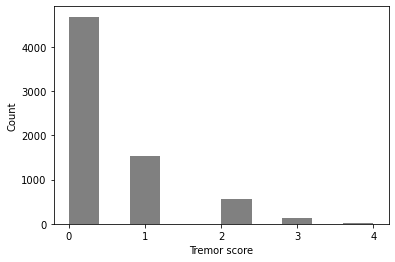

In [110]:
# score distribution
score = df_score['tremor_GENEActivHand'].values
score = np.array(score, dtype=float)
counts, bin_edges = np.histogram(score,bins = range(6))
fig, ax = plt.subplots()
ax.hist(score, histtype='bar', color = 'grey')
ax.set_xlabel('Tremor score')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2,3,4])
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

In [112]:
# Try different task categories
# task categories
task_groups = [['stndg', 'sittg'],['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd'],
               ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']]
# task_code = ['stndg', 'sittg']
# task_code = ['wlkgs', 'wlkgc', 'wlkgp', 'strsu', 'strsd', 'ststd']
# task_code = ['ftnr', 'ftnl', 'ramr', 'raml', 'drawg', 'typng', 'ntblt', 'drnkg', 'orgpa', 'fldng']

In [113]:
is_tasks = df_score['task_code'].isin(task_groups[2]).tolist()
df_feature_task = df_feature[is_tasks]
df_score_task = df_score[is_tasks]

In [114]:
# Removing features with nan
df_feature2 = df_feature_task.dropna(axis=1)
print(df_feature2.shape)

(4554, 2247)


In [115]:
# Removing features with zero variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
df_feature3 = sel.fit_transform(df_feature2)
filter3 = sel.get_support()
feature_names2 = df_feature2.columns
feature_names3 = feature_names2[filter3]
df_feature3 = pd.DataFrame(df_feature3, columns=feature_names3)
print(df_feature3.shape)

(4554, 2149)


In [116]:
score = df_score_task['tremor_GENEActivHand'].values
score = np.array(score, dtype=float)

array([4677, 1531,  558,  132,   11], dtype=int64)

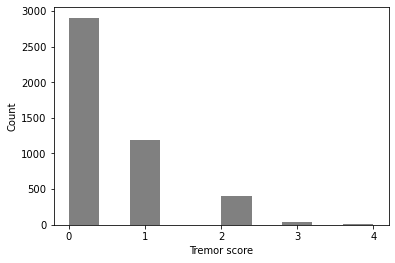

In [117]:
# score distribution
hist, bin_edges = np.histogram(score)
fig, ax = plt.subplots()
ax.hist(score, histtype='bar', color = 'grey')
ax.set_xlabel('Tremor score')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2,3,4])
# save figure
# plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))
counts

In [118]:
# Merge score 3 and 4
score[score==4] = 3
counts, bins = np.histogram(score, bins = range(6))
counts

array([2904, 1190,  407,   53,    0], dtype=int64)

In [119]:
# Univariate Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
test = SelectKBest(score_func=f_classif, k=30)
df_feature4 = test.fit_transform(df_feature3, score)

C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  66  780 1499] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [120]:
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
df_feature4 = pd.DataFrame(df_feature4, columns=feature_names4)

In [121]:
# PCA
X=df_feature4.values
pca = PCA(n_components=10)
fit = pca.fit(X)

In [125]:
# Cumulative explained variance
cumulative_EV = np.cumsum(fit.explained_variance_ratio_)
cumulative_EV

array([0.99999315, 0.99999961, 0.99999976, 0.99999987, 0.99999992,
       0.99999995, 0.99999997, 0.99999998, 0.99999999, 0.99999999])

[Text(0, 0, '0'),
 Text(0, 1, '1'),
 Text(0, 2, '2'),
 Text(0, 3, '3'),
 Text(0, 4, '4')]

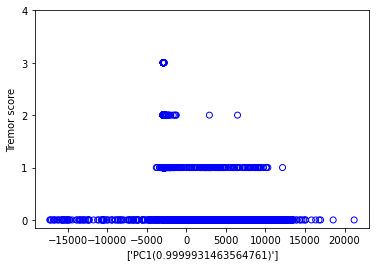

In [127]:
# Use PC1 as a feature to train models? 
X_new = pca.fit_transform(X)
PC1 = X_new[:,0]
x = PC1
y = score
fig, ax = plt.subplots()
ax.scatter(x,y,facecolors='none', edgecolors='b')
ax.set_xlabel(['PC1' + '(' + str(cumulative_EV[0]) + ')'])
ax.set_ylabel('Tremor score')
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(['0','1','2','3','4'])
# save figure
# file_name = 'PC1'
# plt.savefig(os.path.join(save_path,'Train_dataset','SelectKBest','feature_vs_score',file_name))

In [101]:
# What waveform features contribute to PC1?
Y = fit.components_
indices = np.argsort(Y[0])[::-1] # sorting in a descending order
feature_names4[indices]

Index(['y__percentage_of_reoccurring_values_to_all_values',
       'x__percentage_of_reoccurring_values_to_all_values',
       'z__percentage_of_reoccurring_values_to_all_values',
       'z__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'y__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'x__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'y__ar_coefficient__k_10__coeff_2', 'x__has_duplicate',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
       'z__mean_abs_change',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'x__change_qu